This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns. The output is therefore multiclass.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning
* Section 3 - Data preprocessing
* Section 4 - Building an aspect classifier (Accommodation)
* Section 5 - Building an aspect classifier (Food)
* Section 6 - Building an aspect classifier (Attractions)

Dataset needed to run this notebook:

* combinedaspectcheck.xlsx

# Section 1: Import libraries and dataset

In [571]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
import os
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [1064]:
# Bring in manually annotated accommodation data from spreadsheet file
df_accom = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDACCOM",engine = "openpyxl")
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD", engine = "openpyxl")
# df_attract = pd.read_excel("combinedaspectcheck.xlsx, sheet_name = "", engine = "openpyxl")

In [1065]:
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)

# Section 2: Data Cleaning

## Accommodation

In [1066]:
df_accom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigId        2000 non-null   int64  
 1   Cleaned       2000 non-null   object 
 2   Noun Phrases  2000 non-null   object 
 3   Nouns         2000 non-null   object 
 4   Aspect        2000 non-null   object 
 5   Sentiment     2000 non-null   float64
 6   Polarity      2000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 109.5+ KB


In [1067]:
# Positive and negative polarity counts
df_accom["Polarity"].value_counts()

positive    1782
negative     218
Name: Polarity, dtype: int64

In [1068]:
# Aspect value counts
df_accom["Aspect"].value_counts()

Room             310
Food             310
Staff            310
Hotel            309
Entertainment    308
Value            237
Location         208
location           5
entertainment      2
hotel              1
Name: Aspect, dtype: int64

In [1069]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [1070]:
df_accom["Aspect"].value_counts()

Room             310
Hotel            310
Entertainment    310
Food             310
Staff            310
Value            237
Location         213
Name: Aspect, dtype: int64

Mostly balanced categories, the two smaller categories represent those where all datapoints were used but there were just fewer overall.

## Food

In [1071]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2101 non-null   int64  
 1   Cleaned       2101 non-null   object 
 2   Noun Phrases  2101 non-null   object 
 3   Nouns         2101 non-null   object 
 4   Sentiment     2101 non-null   float64
 5   Aspect        2101 non-null   object 
 6   Orig Aspect   2101 non-null   object 
 7   Polarity      2101 non-null   int64  
 8   Unnamed: 9    0 non-null      float64
dtypes: float64(2), int64(2), object(5)
memory usage: 147.9+ KB


In [1072]:
# Positive and negative polarity counts
df_food["Polarity"].value_counts()

0    1843
1     258
Name: Polarity, dtype: int64

In [1073]:
# Aspect value counts
df_food["Aspect"].value_counts()

Menu Choice      351
Food Quality     350
Staff&Service    350
Value            350
Visit Exp        350
Meal Exp         350
Name: Aspect, dtype: int64

## Attractions

In [ ]:
df_attract.info()

In [ ]:
df_attract["Polarity"].value_counts()

In [ ]:
df_attract["Aspect"].value_counts()

# Section 3: Data preprocessing

## Define X and y

In [1074]:
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [1075]:
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)

In [1076]:
print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)

(2000,) (2000,)
(2101,) (2101,)


## Train test split

In [1077]:
# Train, validation, test split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.10, shuffle = True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True)
    return X_train,X_val,X_test,y_train,y_val,y_test

In [1078]:
# Train, validation, test split
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)

In [1079]:
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)

(1800,) (100,) (100,) (1800,) (100,) (100,)
(1890,) (106,) (105,) (1890,) (106,) (105,)


## Encode y and X

In [1080]:
# Function to encode y values as one-hot encoded
def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [1081]:
# Apply function
y_train_accom_e, y_val_accom_e, y_test_accom_e = bin(y_train_accom, y_val_accom, y_test_accom)
y_train_food_e, y_val_food_e, y_test_food_e = bin(y_train_food, y_val_food, y_test_food)

In [1082]:
print(y_train_accom_e.shape, y_val_accom_e.shape, y_test_accom_e.shape)
print(y_train_food_e.shape, y_val_food_e.shape, y_test_food_e.shape)

(1800, 7) (100, 7) (100, 7)
(1890, 6) (106, 6) (105, 6)


In [1083]:
# Get maximum number of nouns to use in the 'maxlen' arguement
print(pd.DataFrame(X_train_accom)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_food)["Nouns"].str.split().apply(len).max())

12
10


In [1084]:
# Fit tokenizer on text and transform to vectors
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=15, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=15, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 15, padding = "post", truncating = "post", value = 0.0)
    
    return X_train_w, X_val_w, X_test_w

In [1085]:
X_train_accom_w, X_val_accom_w, X_test_accom_w = tok(X_train_accom, X_val_accom, X_test_accom)
X_train_food_w, X_val_food_w, X_test_food_w = tok(X_train_food, X_val_food, X_test_food)

In [1086]:
print(X_train_accom_w.shape,y_train_accom_e.shape)
print(X_train_food_w.shape, y_train_food_e.shape)

(1800, 15) (1800, 7)
(1890, 15) (1890, 6)


# Section 4: Building accommodation aspect classifier

## Define functions used for each model

In [678]:
# Visualise the training and test accuracies and losses
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()

In [679]:
# The model will use earlystopping if the valuation loss doesn't decrease after 5 epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = 5),modelcheckpoint]
    return callbacks

In [926]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class):
    classification = classification_report(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    sns.heatmap(cnf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)

In [743]:
# Weight adjustments if required
def weight(y_train):
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    return class_weights

In [750]:
cw_accom = weight(y_accom)
cw_food = weight(y_food)

In [751]:
print(cw_accom)
print(cw_food)

[0.92165899 0.92165899 0.92165899 1.34138162 0.92165899 0.92165899
 1.20554551]
[1. 1. 1. 1. 1. 1.]


## Build Accommodation Model

In [778]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_accom[0],1:cw_accom[1],2:cw_accom[2],3:cw_accom[3],4:cw_accom[4],5:cw_accom[5],6:cw_accom[6]}

In [779]:
# Define model - best performing sentiment model as a starting point
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_shape=(1600,)))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(7, activation='softmax'))

In [780]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_16 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_65 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_67 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
_______________________________________________

In [781]:
output_dir = out('model_output/AccomAspectModels1')
callbacks = call(output_dir)

In [782]:
# Model using keras embeddings
history = model.fit(X_train_accom_w,y_train_accom_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_accom_w, y_val_accom_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
113/113 - 0s - loss: 1.3248 - accuracy: 0.5311 - val_loss: 0.5099 - val_accuracy: 0.8700
Epoch 2/50
113/113 - 0s - loss: 0.3481 - accuracy: 0.9106 - val_loss: 0.3257 - val_accuracy: 0.9200
Epoch 3/50
113/113 - 0s - loss: 0.1378 - accuracy: 0.9678 - val_loss: 0.1555 - val_accuracy: 0.9500
Epoch 4/50
113/113 - 0s - loss: 0.0570 - accuracy: 0.9872 - val_loss: 0.1545 - val_accuracy: 0.9600
Epoch 5/50
113/113 - 0s - loss: 0.0304 - accuracy: 0.9944 - val_loss: 0.0872 - val_accuracy: 0.9600
Epoch 6/50
113/113 - 0s - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.0732 - val_accuracy: 0.9800
Epoch 7/50
113/113 - 0s - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0667 - val_accuracy: 0.9800
Epoch 8/50
113/113 - 0s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0588 - val_accuracy: 0.9800
Epoch 9/50
113/113 - 0s - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0644 - val_accuracy: 0.9800
Epoch 10/50
113/113 - 0s - loss: 6.6672e-04 - accuracy: 1.0000 - val_loss: 0.0688 - val_accuracy: 0.

## Evaluate model

In [786]:
model.evaluate(X_train_accom_w, y_train_accom_e)

57/57 [==============================] - 0s 472us/step - loss: 2.1382e-04 - accuracy: 1.0000


[0.00021381553960964084, 1.0]

In [787]:
model.evaluate(X_val_accom_w, y_val_accom_e)

4/4 [==============================] - 0s 499us/step - loss: 0.0717 - accuracy: 0.9800


[0.07174749672412872, 0.9800000190734863]

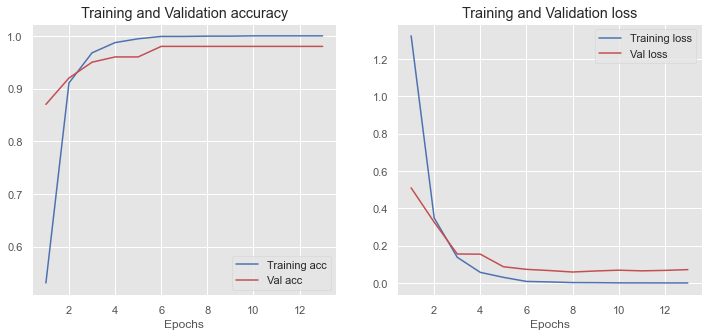

In [788]:
plot_history(history)

In [789]:
# Load model weights from epoch with best validation accuracy
model.load_weights(output_dir+"/weights.06.hdf5")

In [790]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob = model.predict(X_val_accom_w)
y_pred_class = np.argmax(model.predict(X_val_accom_w), axis=-1)
y_val_accom_integer = np.argmax(y_val_accom_e, axis=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.88      0.93        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        10
           4       0.88      1.00      0.94        15
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        12

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



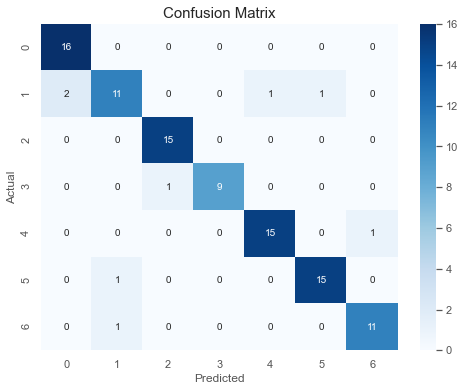

In [791]:
class_conf(y_val_accom_integer,y_pred_class)

In [979]:
# Create dataframe with y pred probabilities, classes and y actual
accom_pred = pd.DataFrame(list(zip(y_val_accom_integer, y_pred_class, y_val_accom)), columns=["Actual Class", "Predicted Class","Actual Aspect"])
accom_pred.head()

,Actual Class,Predicted Class,Actual Aspect
0,6,6,Hotel
1,0,0,Entertainment
2,1,1,Food
3,2,2,Value
4,6,6,Room


In [898]:
# Items not classified correctly
accom_pred[accom_pred["Actual Class"]!= accom_pred["Predicted Class"]]

,Actual Class,Predicted Class,Actual Aspect
17,1,4,Food
36,1,4,Food


The model predicted these as entertainment when they are both clearly referring to food aspects

In [899]:
X_val_accom.iloc[17]

'steak'

In [900]:
X_val_accom.iloc[36]

'flavour'

Analysis:

There is no obvious reason for the misclassifications but there are only two out of the 100 validation set

# Section 5: Building a food aspect classifier

## Build model

In [1113]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 15
batch_size = 16
epochs = 50
class_weights = {0:cw_food[0],1:cw_food[1],2:cw_food[2],3:cw_food[3],4:cw_food[4],5:cw_food[5]}

In [1114]:
# Define model - best performing sentiment model as a starting point
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(512, activation='relu', input_shape=(1600,)))
model2.add(Dense(256,activation = 'relu'))
model2.add(Dense(128,activation = 'relu'))
model2.add(Dense(6, activation='softmax'))

In [1115]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_28 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               123392    
_________________________________________________________________
dense_113 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_114 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_115 (Dense)            (None, 6)                 774       
Total params: 384,390
Trainable params: 384,390
Non-trainable params: 0
_______________________________________________

In [1116]:
output_dir = out('model_output/FoodAspectModels1')
callbacks = call(output_dir)

In [1117]:
# Model using keras embeddings
history2 = model2.fit(X_train_food_w,y_train_food_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_food_w, y_val_food_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
119/119 - 0s - loss: 1.0498 - accuracy: 0.6138 - val_loss: 0.2404 - val_accuracy: 0.9340
Epoch 2/50
119/119 - 0s - loss: 0.2059 - accuracy: 0.9349 - val_loss: 0.1838 - val_accuracy: 0.9528
Epoch 3/50
119/119 - 0s - loss: 0.0930 - accuracy: 0.9757 - val_loss: 0.2134 - val_accuracy: 0.9434
Epoch 4/50
119/119 - 0s - loss: 0.0585 - accuracy: 0.9820 - val_loss: 0.2558 - val_accuracy: 0.9434
Epoch 5/50
119/119 - 0s - loss: 0.0423 - accuracy: 0.9915 - val_loss: 0.2458 - val_accuracy: 0.9528
Epoch 6/50
119/119 - 0s - loss: 0.0396 - accuracy: 0.9921 - val_loss: 0.3346 - val_accuracy: 0.9528
Epoch 7/50
119/119 - 0s - loss: 0.0330 - accuracy: 0.9910 - val_loss: 0.3150 - val_accuracy: 0.9528


In [1118]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.02.hdf5")

## Evaluate model

In [1119]:
print(model2.evaluate(X_train_food_w, y_train_food_e))
print(model2.evaluate(X_val_food_w, y_val_food_e))

60/60 [==============================] - 0s 465us/step - loss: 0.0904 - accuracy: 0.9810
[0.09037983417510986, 0.9809523820877075]
4/4 [==============================] - 0s 740us/step - loss: 0.1838 - accuracy: 0.9528
[0.18376374244689941, 0.9528301954269409]


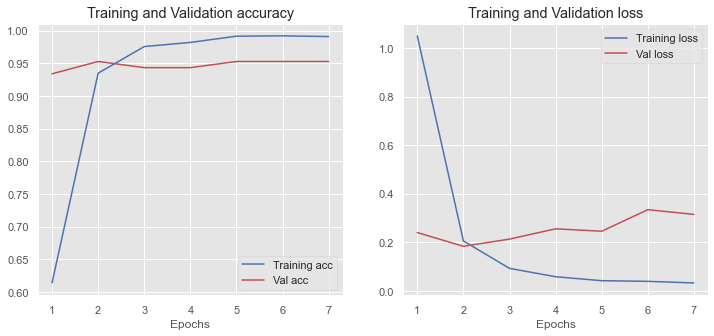

In [1120]:
plot_history(history2)

In [1121]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob2 = model2.predict(X_val_food_w)
y_pred_class2 = np.argmax(model2.predict(X_val_food_w), axis=-1)
y_val_food_integer = np.argmax(y_val_food_e, axis=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.84      0.94      0.89        17
           2       0.95      1.00      0.97        18
           3       1.00      1.00      1.00        17
           4       1.00      0.94      0.97        18
           5       0.94      0.83      0.88        18

    accuracy                           0.95       106
   macro avg       0.95      0.95      0.95       106
weighted avg       0.96      0.95      0.95       106



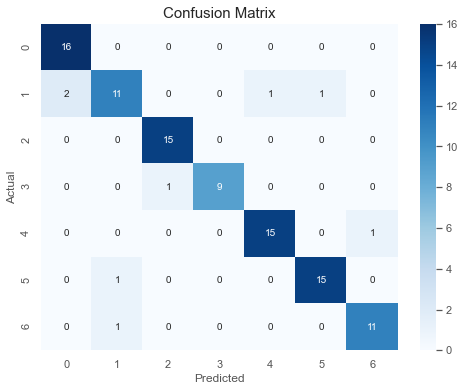

In [1122]:
class_conf(y_val_food_integer,y_pred_class2)

In [1123]:
# Create dataframe with y pred probabilities, classes and y actual
food_pred = pd.DataFrame(list(zip(y_val_food_integer, y_pred_class2, y_val_food)), columns=["Actual Class", "Predicted Class","Actual Aspect"])
food_pred.head(10)

,Actual Class,Predicted Class,Actual Aspect
0,2,2,Menu Choice
1,2,2,Menu Choice
2,4,4,Value
3,5,5,Visit Exp
4,1,1,Meal Exp
5,2,2,Menu Choice
6,3,3,Staff&Service
7,0,0,Food Quality
8,3,3,Staff&Service
9,2,2,Menu Choice


In [1124]:
# Items not classified correctly
food_pred[food_pred["Actual Class"]!= food_pred["Predicted Class"]]

,Actual Class,Predicted Class,Actual Aspect
16,1,5,Meal Exp
23,5,1,Visit Exp
56,4,2,Value
72,5,1,Visit Exp
84,5,1,Visit Exp


## Analysis of the food model results

In [1126]:
X_val_food.iloc[16]

'bank holiday meal'

In [1127]:
X_val_food.iloc[23]

'expectation'

In [1128]:
X_val_food.iloc[56]

'meal express lunch menu value money'

In [1129]:
X_val_food.iloc[72]

'place stay'

In [1130]:
X_val_food.iloc[84]

'walk revisit'

The main problem appears to be the classification between 'meal experience' and 'visit experience'. These are very close categories and the model struggles to classify between them. If the categories are combined the model may perform a little better. In fact there is little benefit in splitting these things anyway since the purpose of the visit is the meal itself and if one is bad the other is likely to be also.

## Recategorise the aspects and re-run the model

In [1135]:
# Combine the two categories
df_food["Aspect"] = df_food["Aspect"].replace("Visit Exp","Meal Exp")
df_food.Aspect.value_counts()

Meal Exp         700
Menu Choice      351
Food Quality     350
Staff&Service    350
Value            350
Name: Aspect, dtype: int64

In [1137]:
# Take random 350 items from this combined category
meal = df_food[df_food["Aspect"] == "Meal Exp"]
meal = meal.sample(n = 350)
meal.shape

(350, 9)

In [1147]:
# Create new dataframe dropping the two aspect categories no longer wanted and then concat with the new combined category
aspect_list = ["Menu Choice","Food Quality","Staff&Service","Value"]
df_food_new = df_food[df_food["Aspect"].isin(aspect_list)]
df_food_new = pd.concat([df_food_new,meal],axis = 0,ignore_index = True)
df_food_new.drop(columns = "Unnamed: 9", axis = 1, inplace = True)
df_food_new.head(2)

,OrigInd,Cleaned,Noun Phrases,Nouns,Sentiment,Aspect,Orig Aspect,Polarity
0,56424,really good quality sausage nice friendly welc...,good quality sausage,quality sausage,0.4404,Food Quality,Quality,0
1,48050,quality breakfast river fabulous breakfast nex...,quality breakfast river fabulous breakfast,quality breakfast river breakfast,0.5267,Food Quality,Quality,0


In [1150]:
# Define X and y, train, test, split and encode X and y variables
X_food_new,y_food_new = XY(df_food_new)
X_train_food2,X_val_food2,X_test_food2,y_train_food2,y_val_food2,y_test_food2 = train_test(X_food_new,y_food_new)
y_train_food_e2, y_val_food_e2, y_test_food_e2 = bin(y_train_food2, y_val_food2, y_test_food2)
X_train_food_w2, X_val_food_w2, X_test_food_w2 = tok(X_train_food2, X_val_food2, X_test_food2)

In [1165]:
# Define model - set output to only 5 categories

model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(512, activation='relu', input_shape=(1600,)))
model3.add(Dense(256,activation = 'relu'))
model3.add(Dense(128,activation = 'relu'))
model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 15, 16)            96000     
_________________________________________________________________
flatten_30 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               123392    
_________________________________________________________________
dense_121 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_122 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_123 (Dense)            (None, 5)                 645       
Total params: 384,261
Trainable params: 384,261
Non-trainable params: 0
_______________________________________________

In [1152]:
# Set output directory and callbacks
output_dir = out('model_output/FoodAspectModels2')
callbacks = call(output_dir)

In [1153]:
# Run model

history3 = model3.fit(X_train_food_w2,y_train_food_e2,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_food_w2, y_val_food_e2),
                    batch_size=batch_size,
                     )

Epoch 1/50
99/99 - 0s - loss: 0.8896 - accuracy: 0.6902 - val_loss: 0.1491 - val_accuracy: 0.9659
Epoch 2/50
99/99 - 0s - loss: 0.1362 - accuracy: 0.9606 - val_loss: 0.0398 - val_accuracy: 0.9886
Epoch 3/50
99/99 - 0s - loss: 0.0739 - accuracy: 0.9765 - val_loss: 0.1099 - val_accuracy: 0.9773
Epoch 4/50
99/99 - 0s - loss: 0.0503 - accuracy: 0.9848 - val_loss: 0.0332 - val_accuracy: 0.9886
Epoch 5/50
99/99 - 0s - loss: 0.0386 - accuracy: 0.9917 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 6/50
99/99 - 0s - loss: 0.0227 - accuracy: 0.9956 - val_loss: 0.0960 - val_accuracy: 0.9773
Epoch 7/50
99/99 - 0s - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 8/50
99/99 - 0s - loss: 0.0257 - accuracy: 0.9930 - val_loss: 0.0302 - val_accuracy: 0.9773
Epoch 9/50
99/99 - 0s - loss: 0.0218 - accuracy: 0.9962 - val_loss: 0.0289 - val_accuracy: 0.9886
Epoch 10/50
99/99 - 0s - loss: 0.0201 - accuracy: 0.9956 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 11/50
99/99 -

In [1166]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.05.hdf5")

In [1167]:
print(model3.evaluate(X_train_food_w2, y_train_food_e2))
print(model3.evaluate(X_val_food_w2, y_val_food_e2))

50/50 [==============================] - 0s 443us/step - loss: 0.0190 - accuracy: 0.9956
[0.019030462950468063, 0.995555579662323]
3/3 [==============================] - 0s 666us/step - loss: 0.0127 - accuracy: 1.0000
[0.012695959769189358, 1.0]


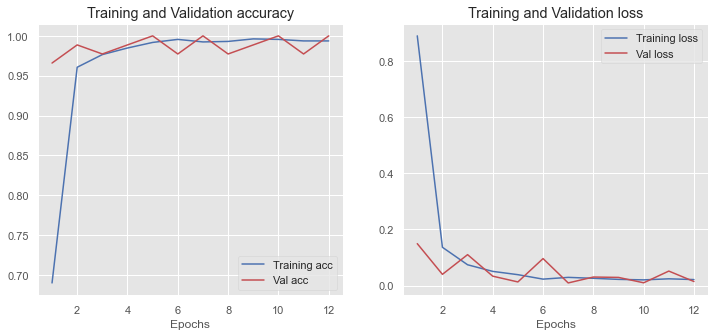

In [1168]:
plot_history(history3)

In [1169]:
# Get predicted y values and predicted classes and convert original labels to integers
y_pred_prob3 = model3.predict(X_val_food_w2)
y_pred_class3 = np.argmax(model3.predict(X_val_food_w2), axis=-1)
y_val_food_integer = np.argmax(y_val_food_e2, axis=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        18

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88



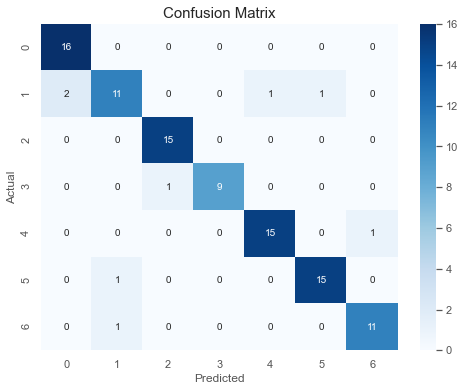

In [1170]:
class_conf(y_val_food_integer,y_pred_class3)

In [1171]:
# Create dataframe with y pred probabilities, classes and y actual
food_pred2 = pd.DataFrame(list(zip(y_val_food_integer, y_pred_class3, y_val_food2)), columns=["Actual Class", "Predicted Class","Actual Aspect"])
food_pred2.head(10)

,Actual Class,Predicted Class,Actual Aspect
0,0,0,Food Quality
1,3,3,Staff&Service
2,1,1,Meal Exp
3,2,2,Menu Choice
4,3,3,Staff&Service
5,3,3,Staff&Service
6,4,4,Value
7,1,1,Meal Exp
8,0,0,Food Quality
9,3,3,Staff&Service


In [1172]:
# Items not classified correctly
food_pred2[food_pred2["Actual Class"]!= food_pred2["Predicted Class"]]

,Actual Class,Predicted Class,Actual Aspect


Combining the aspects of Visit Experience and Meal Experience has improved the prediction with the model to 100%

# Section 6: Building an attraction model

## Build a model

# Section 5: Data Augmentation

In [470]:
accom_eda = pd.concat([X_accom,y_accom],axis = 1)
accom_eda = accom_eda.sample(frac=1)
accom_eda.head()

,Nouns,Aspect
1967,alarm,Room
1467,hotel,Hotel
1927,room food good,Food
826,entertainment team,Entertainment
1017,fun holiday,Entertainment


In [471]:
# Get number of words in each row, split dataframes into those with more than 1 word and those with 1
accom_eda["Count"] = accom_eda["Nouns"].apply(lambda x: len(x.split()))
accom_eda_old = accom_eda[accom_eda["Count"]==1]
accom_eda_new = accom_eda[accom_eda["Count"]>1]

In [472]:
# Check the distribution of number of words
accom_eda_new["Count"].value_counts()

2     709
3     317
4     120
5      48
6      18
7       7
8       2
10      1
12      1
Name: Count, dtype: int64

Most lines have two words, this will inform the augmentation process

In [473]:
# Get shape of dataframes
accom_eda_new.reset_index(inplace = True)
accom_eda_old.reset_index(inplace = True)
accom_eda_new.drop(columns = ["Count"],axis = 1, inplace = True)
accom_eda_old.drop(columns = ["Count"],axis = 1,inplace = True)
print(accom_eda_new.shape, accom_eda_old.shape)

(1223, 3) (777, 3)


In [474]:
# Check head
accom_eda_new.sample(5)

,index,Nouns,Aspect
707,1808,note staff,Staff
941,1441,place hotel,Hotel
690,805,hour fun family,Entertainment
1104,1158,value money,Value
195,765,family fun bike pedal,Entertainment


## Synonym replacement

Distribution above suggests most rows only have two words, so replacement of one word is used in the augmentation

In [477]:
# Take sample
test = accom_eda_new["Nouns"].iloc[4]
test

'plenty room'

In [478]:
# Run synonym replacement
from textaugment import EDA
t = EDA()
t.synonym_replacement(test,n = 1)

'quite a little room'

In [479]:
# Apply to the whole dataframe and conat to original df
replaced = pd.DataFrame(accom_eda_new["Nouns"].apply(lambda x: t.synonym_replacement(x)))
replaced = pd.concat([replaced,accom_eda_new.Aspect],axis = 1)
replaced.head()

,Nouns,Aspect
0,room food for thought good,Food
1,entertainment team up,Entertainment
2,play holiday,Entertainment
3,lack faculty,Staff
4,plenty way,Room


In [480]:
# Append to original phrases and then append to the rows that were not replaced
accom_eda_one = accom_eda_new.append(replaced)
accom_eda_one = accom_eda_one.append(accom_eda_old)

In [481]:
# New training data shape
accom_eda_one.shape

(3223, 3)

In [482]:
accom_eda_one.head()

,index,Nouns,Aspect
0,1927.0,room food good,Food
1,826.0,entertainment team,Entertainment
2,1017.0,fun holiday,Entertainment
3,319.0,lack staff,Staff
4,60.0,plenty room,Room


## Random deletion

In [483]:
# Take sample
test = accom_eda_new["Nouns"].iloc[4]
test

'plenty room'

In [484]:
# Delete a random word in the sentence with a probability of 0.2
t.random_deletion(test, p=0.2)

'plenty'

In [485]:
# Apply to the dataset with at least one word
deleted = pd.DataFrame(accom_eda_new["Nouns"].apply(lambda x: t.random_deletion(x,p = 0.2)))
deleted = pd.concat([deleted,accom_eda_new.Aspect],axis = 1)
deleted.head()

,Nouns,Aspect
0,room food good,Food
1,entertainment team,Entertainment
2,fun holiday,Entertainment
3,staff,Staff
4,plenty room,Room


In [486]:
# Append to original phrases and then append to the rows that were not replaced
accom_eda_two = accom_eda_one.append(deleted)
accom_eda_two.head()

,index,Nouns,Aspect
0,1927.0,room food good,Food
1,826.0,entertainment team,Entertainment
2,1017.0,fun holiday,Entertainment
3,319.0,lack staff,Staff
4,60.0,plenty room,Room


In [487]:
accom_eda_two.shape

(4446, 3)

In [488]:
accom_eda_two.head()

,index,Nouns,Aspect
0,1927.0,room food good,Food
1,826.0,entertainment team,Entertainment
2,1017.0,fun holiday,Entertainment
3,319.0,lack staff,Staff
4,60.0,plenty room,Room


## Random swap

In [489]:
# Take sample
test = accom_eda_new["Nouns"].iloc[4]
test

'plenty room'

In [492]:
t.random_swap(test, n = 1)

'room plenty'

In [493]:
# Apply to the dataset with at least one word (use n = 1 as there may only be two words in the sentence)
swapped = pd.DataFrame(accom_eda_new["Nouns"].apply(lambda x: t.random_swap(x,n  = 1)))
swapped = pd.concat([swapped,accom_eda_new.Aspect],axis = 1)
swapped.head()

,Nouns,Aspect
0,room good food,Food
1,team entertainment,Entertainment
2,holiday fun,Entertainment
3,staff lack,Staff
4,room plenty,Room


In [494]:
# Append to original phrases and then append to the rows that were not replaced
accom_eda_three = accom_eda_two.append(swapped)
accom_eda_three.shape

(5669, 3)

## Random insertion

In [495]:
t.random_insertion(test, n = 2)

'way way plenty room'

In [496]:
t.random_insertion(test)

'plenty way room'

In [497]:
# Apply to the dataset 
insert = pd.DataFrame(accom_eda_three["Nouns"].apply(lambda x: t.random_insertion(x,n  = 1)))
insert = pd.concat([insert,accom_eda_three.Aspect],axis = 1)
insert.shape

(5669, 2)

In [498]:
# Append to original dataframe
accom_eda_four = accom_eda_three.append(insert)
accom_eda_four.drop(columns = ["index"],axis = 1, inplace = True)
accom_eda_four.shape

(11338, 2)

In [499]:
accom_eda_four.sample(5)

,Nouns,Aspect
118,hotel edna,Hotel
1013,emplacement location location ambiance hotel,Location
608,space hotel,Hotel
951,staff staff faculty reception restaurant fault...,Staff
790,fabulous fab hotel,Hotel


In [500]:
accom_eda_four.Aspect.value_counts()

Entertainment    2024
Food             1916
Room             1730
Staff            1652
Value            1524
Hotel            1430
Location         1062
Name: Aspect, dtype: int64

In [501]:
accom_eda_four.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11338 entries, 0 to 1222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Nouns   11338 non-null  object
 1   Aspect  11338 non-null  object
dtypes: object(2)
memory usage: 265.7+ KB


# Section 6: Use augmented data in model

Data has to be encoded manually as the encoder applies different encoding depending on the order of the aspects. The validation set needs to be kept as it is untouched and the aspects in the new data coded the same way in order to assess the output of the model properly.

In [548]:
pd.DataFrame(y_accom).Aspect.value_counts()

Room             310
Hotel            310
Entertainment    310
Food             310
Staff            310
Value            237
Location         213
Name: Aspect, dtype: int64

In [549]:
# Use to get the one hot encoded representation as per the y_val data
amalgamated = pd.concat([y_accom,pd.DataFrame(y_accom_e.tolist())],axis = 1,ignore_index = True)
amalgamated[amalgamated[0] == "Location"].head()

,0,1,2,3,4,5,6,7
1019,Location,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1021,Location,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1024,Location,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1028,Location,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1036,Location,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [550]:
# Apply to each aspect
Room = [0,0,0,0,1,0,0]
Hotel = [0,0,1,0,0,0,0]
Entertainment = [1,0,0,0,0,0,0]
Food = [0,1,0,0,0,0,0]
Staff = [0,0,0,0,0,1,0]
Value = [0,0,0,0,0,0,1]
Location = [0,0,0,1,0,0,0]

In [331]:
# Define model - best performing sentiment model as a starting point
model = Sequential()
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model.add(Flatten())
model.add(Dense(512, activation='relu', input_shape=(1600,)))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 16)            96000     
_________________________________________________________________
flatten_6 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               123392    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 903       
Total params: 384,519
Trainable params: 384,519
Non-trainable params: 0
________________________________________________

In [332]:
output_dir = out('model_output/AugmentAccomModels1')
callbacks = call(output_dir)

In [333]:
# Model using keras embeddings
history = model.fit(X_train_accom_w,y_train_accom_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_accom_w, y_val_accom_e),
                    batch_size=batch_size,
                    class_weight = class_weights)

Epoch 1/50
638/638 - 1s - loss: 0.5101 - accuracy: 0.8373 - val_loss: 3.5583 - val_accuracy: 0.4000
Epoch 2/50
638/638 - 1s - loss: 0.0996 - accuracy: 0.9743 - val_loss: 4.3219 - val_accuracy: 0.3800
Epoch 3/50
638/638 - 1s - loss: 0.0672 - accuracy: 0.9828 - val_loss: 5.7195 - val_accuracy: 0.3500
Epoch 4/50
638/638 - 1s - loss: 0.0541 - accuracy: 0.9870 - val_loss: 5.7786 - val_accuracy: 0.3400
Epoch 5/50
638/638 - 1s - loss: 0.0437 - accuracy: 0.9898 - val_loss: 5.7048 - val_accuracy: 0.3800
Epoch 6/50
638/638 - 1s - loss: 0.0428 - accuracy: 0.9912 - val_loss: 5.1414 - val_accuracy: 0.3800


In [334]:
model.evaluate(X_train_accom_w,y_train_accom_e)

319/319 [==============================] - 0s 439us/step - loss: 0.0408 - accuracy: 0.9901


[0.04084132984280586, 0.9900980591773987]

In [335]:
model.evaluate(X_val_accom_w,y_val_accom_e)

4/4 [==============================] - 0s 742us/step - loss: 5.1414 - accuracy: 0.3800


[5.141357898712158, 0.3799999952316284]

In [341]:
# Get predicted y values and predicted classes
y_pred_prob = model.predict(X_val_accom_w)
y_pred_class = (model.predict(X_val_accom_w) > 0.5).astype("int32")

This model does not perform as well as the accommodation model. This is in part due to the fact that food reviews tend to be shorter, mention multiple topics in the one noun phrase. The labelling of the model took the first mentioned aspect in a noun phrase as the one that it was labelled as, for example if a row had nouns "Food", "Service", then the word "Food" is the one that is used to label the data. This means that some of the rows will be by nature fuzzy.

Where reviews lack punctuation, those rows cannot be split into sentences, then noun phrases properly. This results in many nouns for a datapoint which compounds the problem above and confuses the model. One measure might be to exclude those datapoints where the number of nouns is more than say 3 or 4 but there would still be cases where at least two aspects are mentioned in a single noun-phrase.
